In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

About the dataset:

1. train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

2. PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
3. HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
4. CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
5. Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
6. Destination - The planet the passenger will be debarking to.
7. Age - The age of the passenger.
8. VIP - Whether the passenger has paid for special VIP service during the voyage.
9. RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
10. Name - The first and last names of the passenger.
11. Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

12.  test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. 

Your task is to predict the value of Transported for the passengers in this set.

13. sample_submission.csv - A submission file in the correct format.
14. PassengerId - Id for each passenger in the test set.
15. Transported - The target. For each passenger, predict either True or False

In [2]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
#Dropping useless columns: Cabin, Name
data.drop(['Cabin', 'Name'], axis=1, inplace=True)

In [4]:
data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

# Handling Missing Values

There are different measures for handling of missing categorical data, numerical data, continuous data etc. 

Columns null values replaced with mean: 
1. RoomService
2. FoodCourt
3. ShoppingMall
4. Spa
5. VRDeck

Columns null values replaced with mode:
1. HomePlanet
2. CryoSleep
3. Destination
4. VIP

Columns null values replaced with median:
1. Age

In [5]:
#Replacing columns with mean (Might not be a wise choise if there are any outliers)
data['RoomService'] = data['RoomService'].fillna(data['RoomService'].mean())
data['FoodCourt'] = data['FoodCourt'].fillna(data['FoodCourt'].mean())
data['ShoppingMall'] = data['ShoppingMall'].fillna(data['ShoppingMall'].mean())
data['Spa'] = data['Spa'].fillna(data['Spa'].mean())
data['VRDeck'] = data['VRDeck'].fillna(data['VRDeck'].mean())

In [6]:
#Replacing columns with mode (i.e. frequently occuring value in categorical variables)
data['HomePlanet'] = data['HomePlanet'].fillna(data['HomePlanet'].mode()[0])
data['CryoSleep'] = data['CryoSleep'].fillna(data['CryoSleep'].mode()[0])
data['Destination'] = data['Destination'].fillna(data['Destination'].mode()[0])
data['VIP'] = data['VIP'].fillna(data['VIP'].mode()[0])

In [7]:
#Replacing columns with median
data['Age'] = data['Age'].fillna(data['Age'].median())

Observing the distributions and outliers in the continuous value columns (the ones replaced using mean).

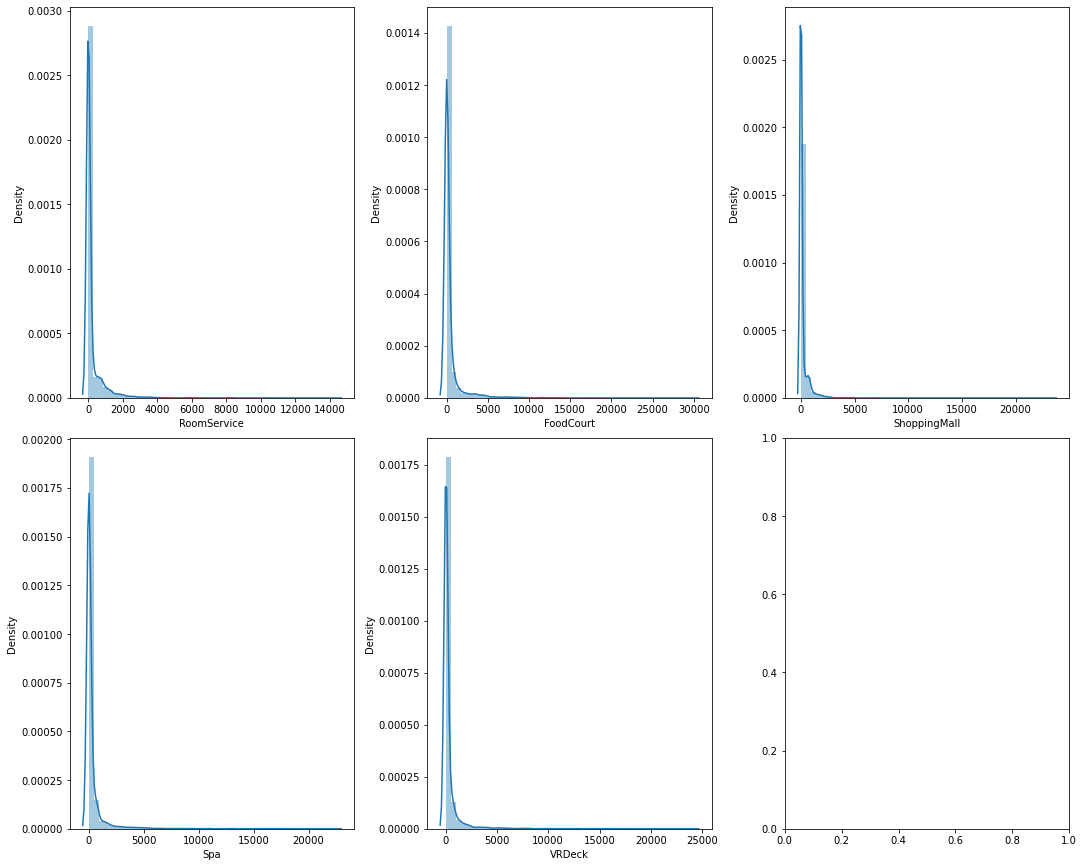

In [8]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize=(15,12))
i = 0
ax = ax.flatten()

sns.distplot(data['RoomService'], ax = ax[0])
sns.distplot(data['FoodCourt'], ax = ax[1])
sns.distplot(data['ShoppingMall'], ax = ax[2])
sns.distplot(data['Spa'], ax = ax[3])
sns.distplot(data['VRDeck'], ax = ax[4])

plt.tight_layout(pad = 0.5, w_pad=0.7, h_pad=0.5)

As majority of the values are near 0 and are full of outluers, its better to drop these columns.

In [9]:
#data.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)

Exploring the categorical columns using bar plots to observe their frequency distributions.

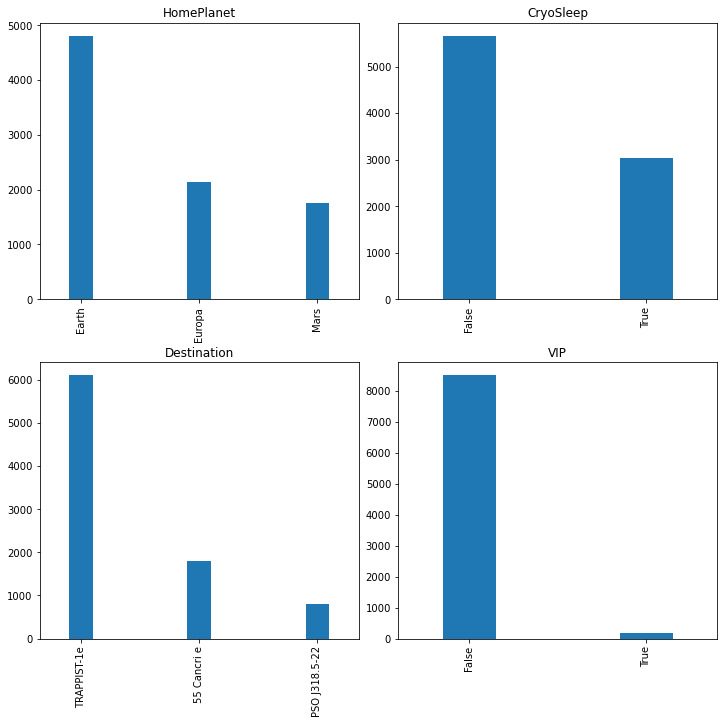

In [10]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize=(10,10))
i = 0
ax = ax.flatten()

data['HomePlanet'].value_counts().plot(kind='bar', ax = ax[0], width=0.2, title='HomePlanet')
data['CryoSleep'].value_counts().plot(kind='bar', ax = ax[1], width=0.3, title='CryoSleep')
data['Destination'].value_counts().plot(kind='bar', ax = ax[2], width=0.2, title='Destination')
data['VIP'].value_counts().plot(kind='bar', ax = ax[3], width=0.3, title='VIP')

plt.tight_layout(pad = 0.5, w_pad=0.7, h_pad=0.5)

The VIP Column seems to be interesting seeing the total number of VIPs throught the complete dataset. Dropping this column as it can mess up our machine learning model at a later stage. 

In [11]:
data.drop('VIP', axis=1, inplace=True)

There doesn't seem to be any reason for using passenger id while training our model. So dropping the columns.

In [12]:
data.drop('PassengerId', axis=1, inplace=True)

In [13]:
data.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True


# Encoding the categorical columns

In [14]:
t_dummy = pd.get_dummies(data['HomePlanet'])
c_dummy = pd.get_dummies(data['CryoSleep'])
d_dummy = pd.get_dummies(data['Destination'])

In [15]:
m1 = pd.concat([data, t_dummy], axis=1)
m2 = pd.concat([m1, c_dummy], axis=1)
m3 = pd.concat([m2, d_dummy], axis=1)
m3

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Earth,Europa,Mars,False,True,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,0,1,0,1,0,0,0,1
1,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,1,0,0,1,0,0,0,1
2,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,1,0,1,0,0,0,1
3,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,1,0,1,0,0,0,1
4,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,0.0,6819.0,0.0,1643.0,74.0,False,0,1,0,1,0,1,0,0
8689,Earth,True,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,False,1,0,0,0,1,0,1,0
8690,Earth,False,TRAPPIST-1e,26.0,0.0,0.0,1872.0,1.0,0.0,True,1,0,0,1,0,0,0,1
8691,Europa,False,55 Cancri e,32.0,0.0,1049.0,0.0,353.0,3235.0,False,0,1,0,1,0,1,0,0


In [16]:
#Dropping the original categorical columns
final = m3.drop(['HomePlanet', 'CryoSleep', 'Destination'], axis=1)
final.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Earth,Europa,Mars,False,True,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0,1,0,1,0,0,0,1
1,24.0,109.0,9.0,25.0,549.0,44.0,True,1,0,0,1,0,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,1,0,1,0,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,1,0,1,0,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,0,0,1,0,0,0,1


<AxesSubplot:>

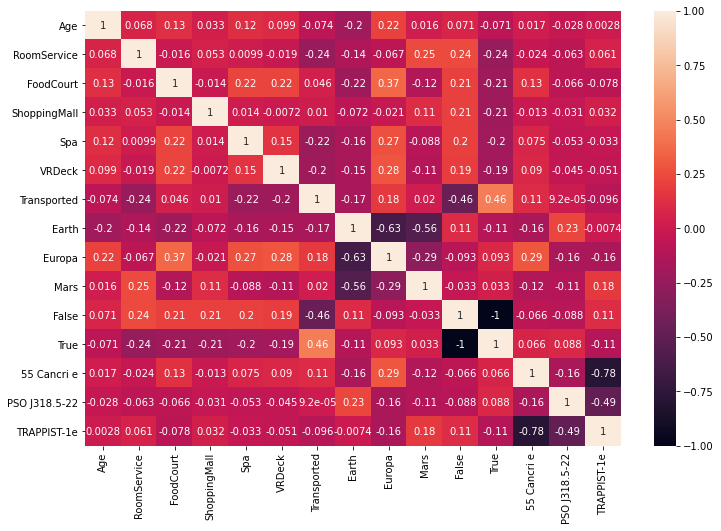

In [17]:
#Finding correlation between columns
plt.figure(figsize=(12, 8))
sns.heatmap(final.corr(), annot=True)

<AxesSubplot:xlabel='Age', ylabel='Density'>

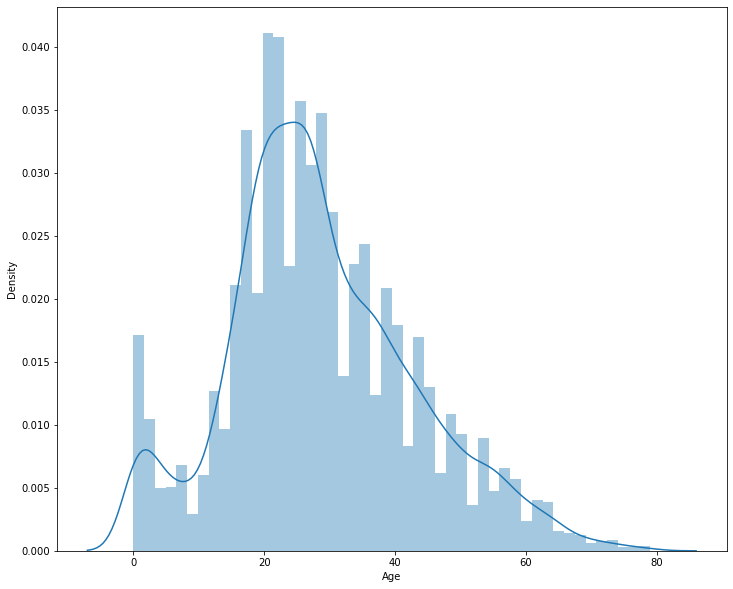

In [18]:
plt.figure(figsize=(12, 10))
sns.distplot(data['Age'])

# Scaling the Continuous Column

Before training the model, the values of age can decrease the efficiency of learning, so scaling the age values:

In [22]:
age = final['Age'].values.reshape(-1, 1)
roomservice = final['RoomService'].values.reshape(-1, 1)
foodcourt = final['FoodCourt'].values.reshape(-1, 1)
shopping = final['ShoppingMall'].values.reshape(-1, 1)
spa = final['Spa'].values.reshape(-1, 1)
vrd = final['VRDeck'].values.reshape(-1, 1)

In [20]:
scalar = MinMaxScaler()

In [23]:
scaled_age = scalar.fit_transform(age)
scaled_room = scalar.fit_transform(roomservice)
scaled_food = scalar.fit_transform(foodcourt)
scaled_shop = scalar.fit_transform(shopping)
scaled_spa = scalar.fit_transform(spa)
scaled_vrd = scalar.fit_transform(vrd)

In [24]:
final['Age'] = scaled_age
final['RoomService'] = scaled_room
final['FoodCourt'] = scaled_food
final['ShoppingMall'] = scaled_shop
final['Spa'] = scaled_spa
final['VRDeck'] = scaled_vrd

In [25]:
final.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Earth,Europa,Mars,False,True,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,False,0,1,0,1,0,0,0,1
1,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,True,1,0,0,1,0,0,0,1
2,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,False,0,1,0,1,0,0,0,1
3,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,False,0,1,0,1,0,0,0,1
4,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,True,1,0,0,1,0,0,0,1


# Training and Testing Split data

In [26]:
X = final.drop('Transported', axis=1)
Y = final['Transported']

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

The following classification models will be trained:

1. Logistic Regression (Base Model)
2. Naive Bayes 
3. Random Forest

# Base Model: Logistic Regression

In [28]:
lr = LogisticRegression()

In [29]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01, 0.001]

In [30]:
LRgrid = dict(solver=solvers,penalty=penalty,C=c_values)

In [31]:
LRcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [32]:
LRgrid_search = GridSearchCV(estimator=lr, param_grid=LRgrid, n_jobs=-1, cv=LRcv, scoring='accuracy',error_score=0)

In [33]:
LRgrid_result = LRgrid_search.fit(X, Y)

In [34]:
print("Best: %f using %s" % (LRgrid_result.best_score_, LRgrid_result.best_params_))

Best: 0.785420 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [35]:
means = LRgrid_result.cv_results_['mean_test_score']
stds = LRgrid_result.cv_results_['std_test_score']
params = LRgrid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.785267 (0.014860) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.785343 (0.014881) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.785420 (0.014829) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.780013 (0.013452) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.779975 (0.013505) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.780013 (0.013452) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.764561 (0.012001) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.764600 (0.012056) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.764600 (0.012031) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.747230 (0.012812) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.747230 (0.012812) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.747268 (0.012900) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.715365 (0.012289) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.715365 (0.01228

In [38]:
lr = LogisticRegression(C=100, solver='liblinear')

In [39]:
lr.fit(X_train, Y_train)

LogisticRegression(C=100, solver='liblinear')

In [40]:
lrp = lr.predict(X_test)

In [48]:
print(confusion_matrix(Y_test, lrp))
print(classification_report(Y_test, lrp))

[[678 204]
 [151 706]]
              precision    recall  f1-score   support

       False       0.82      0.77      0.79       882
        True       0.78      0.82      0.80       857

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



# SVM Classifier

In [50]:
from sklearn.svm import SVC

In [52]:
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

# define grid search
SVCgrid = dict(kernel=kernel,C=C,gamma=gamma)
SVCcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
SVCgrid_search = SVCGridSearchCV(estimator=model, param_grid=SVCgrid, n_jobs=-1, cv=SVCcv, scoring='accuracy',error_score=0)
SVCgrid_result = SVCgrid_search.fit(X, Y)

# summarize results
print("Best: %f using %s" % (SVCgrid_result.best_score_, SVCgrid_result.best_params_))

Best: 0.785881 using {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}


In [53]:
means = SVCgrid_result.cv_results_['mean_test_score']
stds = SVCgrid_result.cv_results_['std_test_score']
params = SVCgrid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.785881 (0.013518) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.782852 (0.012516) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.612564 (0.024267) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.782122 (0.012876) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.775489 (0.013128) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.594654 (0.024125) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.766555 (0.011424) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.759653 (0.011872) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.620996 (0.033564) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.742437 (0.012191) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.720235 (0.012434) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.598716 (0.024742) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.718279 (0.012506) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
0.718279 (0.012506) with: {'C': 0.01, 'gamma': '

In [81]:
svc = SVC(C=50, gamma='scale', kernel='poly', probability=True)

In [82]:
svc.fit(X_train, Y_train)

SVC(C=50, kernel='poly', probability=True)

In [83]:
svcp = svc.predict(X_test)

In [84]:
print(confusion_matrix(Y_test, svcp))
print(classification_report(Y_test, svcp))

[[681 201]
 [160 697]]
              precision    recall  f1-score   support

       False       0.81      0.77      0.79       882
        True       0.78      0.81      0.79       857

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



# Naive Bayes Classifier

In [59]:
nb = GaussianNB()

In [60]:
nb.fit(X_train, Y_train)

GaussianNB()

In [61]:
nbp = nb.predict(X_test)

In [62]:
print(confusion_matrix(Y_test, nbp))
print(classification_report(Y_test, nbp))

[[512 370]
 [ 84 773]]
              precision    recall  f1-score   support

       False       0.86      0.58      0.69       882
        True       0.68      0.90      0.77       857

    accuracy                           0.74      1739
   macro avg       0.77      0.74      0.73      1739
weighted avg       0.77      0.74      0.73      1739



# Random Forest Classifier

In [63]:
rf = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

In [65]:
RFgrid = dict(n_estimators=n_estimators,max_features=max_features)
RFcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
RFgrid_search = GridSearchCV(estimator=rf, param_grid=RFgrid, n_jobs=-1, cv=RFcv, scoring='accuracy',error_score=0)
RFgrid_result = RFgrid_search.fit(X, Y)

In [69]:
print("Best: %f using %s" % (RFgrid_result.best_score_, RFgrid_result.best_params_))

Best: 0.782660 using {'max_features': 'sqrt', 'n_estimators': 1000}


In [67]:
means = RFgrid_result.cv_results_['mean_test_score']
stds = RFgrid_result.cv_results_['std_test_score']
params = RFgrid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.772422 (0.012956) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.781241 (0.013897) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.782660 (0.014972) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.772537 (0.015763) with: {'max_features': 'log2', 'n_estimators': 10}
0.780283 (0.015918) with: {'max_features': 'log2', 'n_estimators': 100}
0.782008 (0.015737) with: {'max_features': 'log2', 'n_estimators': 1000}


In [75]:
rf = RandomForestClassifier(n_estimators=1000, max_features='sqrt')

In [76]:
rf.fit(X_train, Y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=1000)

In [77]:
rfp = rf.predict(X_test)

In [78]:
print(confusion_matrix(Y_test, rfp))
print(classification_report(Y_test, rfp))

[[697 185]
 [176 681]]
              precision    recall  f1-score   support

       False       0.80      0.79      0.79       882
        True       0.79      0.79      0.79       857

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



# ROC Curves

Calculating probabilities for the predicted values. 

In [85]:
r_prob = [0 for _ in range(len(Y_test))] #Dividing the curve
lr_prob = lr.predict_proba(X_test) #Base Model Logistic Regression
svm_prob = svc.predict_proba(X_test) #SVM
nb_prob = nb.predict_proba(X_test) #Naive Bayes
rf_prob = rf.predict_proba(X_test) #Random Forest

Only positive outcomes are kept

In [86]:
lr_prob = lr_prob[:, 1]
svm_prob = svm_prob[:, 1]
nb_prob = nb_prob[:, 1]
rf_prob = rf_prob[:, 1]

Encoding the Transported values 

In [118]:
y_t = []
for i in Y_test.astype('string'):
    if i == 'True':
        y_t.append(1)
    else:
        y_t.append(0)

Calculating ROC curve

In [120]:
r_auc = roc_auc_score(Y_test, r_prob)
lr_auc = roc_auc_score(Y_test, lr_prob)
svm_auc = roc_auc_score(Y_test, svm_prob)
nb_auc = roc_auc_score(Y_test, nb_prob)
rf_auc = roc_auc_score(Y_test, rf_prob)

In [121]:
print('Random (Chance) Prediction: AUROC = %.3f' % (r_auc))
print('Logistic Regression: AUROC = %.3f' % (lr_auc))
print('SVM: AUROC = %.3f' % (svm_auc))
print('Naive Bayes: AUROC = %.3f' % (nb_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))

Random (Chance) Prediction: AUROC = 0.500
Logistic Regression: AUROC = 0.873
SVM: AUROC = 0.877
Naive Bayes: AUROC = 0.861
Random Forest: AUROC = 0.865


Calculating true positive and false positive rates

In [122]:
r_fpr, r_tpr, _ = roc_curve(np.array(y_t) , np.array(r_prob))
lr_fpr, lr_tpr, _ = roc_curve(np.array(y_t) , np.array(lr_prob))
svm_fpr, svm_tpr, _ = roc_curve(np.array(y_t) , np.array(svm_prob))
nb_fpr, nb_tpr, _ = roc_curve(np.array(y_t) , np.array(nb_prob))
rf_fpr, rf_tpr, _ = roc_curve(np.array(y_t) , np.array(rf_prob))

Visualising the ROC Curve

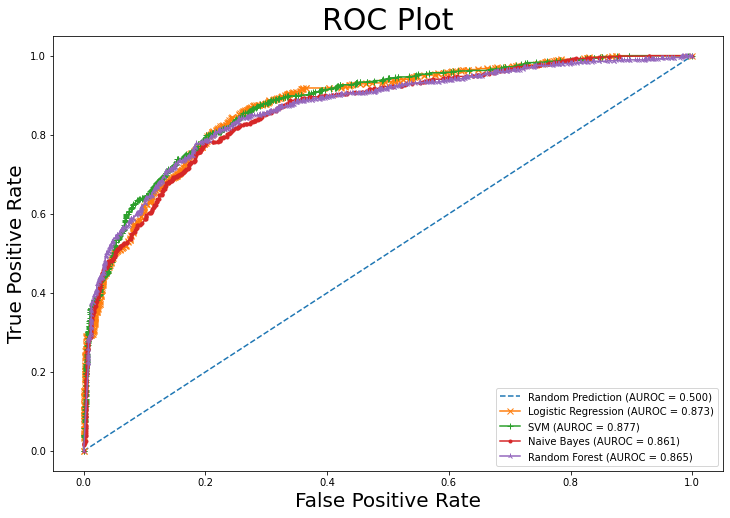

In [132]:
plt.figure(figsize=(12, 8))
plt.plot(r_fpr, r_tpr, linestyle = '--', label = 'Random Prediction (AUROC = %0.3f)' % r_auc)
plt.plot(lr_fpr, lr_tpr, marker = 'x', label = 'Logistic Regression (AUROC = %0.3f)' % lr_auc)
plt.plot(svm_fpr, svm_tpr, marker = '+', label = 'SVM (AUROC = %0.3f)' % svm_auc)
plt.plot(nb_fpr, nb_tpr, marker = '.', label = 'Naive Bayes (AUROC = %0.3f)' % nb_auc)
plt.plot(rf_fpr, rf_tpr, marker = '2', label = 'Random Forest (AUROC = %0.3f)' % rf_auc)

plt.title('ROC Plot', size=30)
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.legend()
plt.show()

# Pre-processing the required Test Data

In [218]:
test = pd.read_csv('test.csv')
temp_test = test.copy()

In [219]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [220]:
#Dropping the columns: PassengerId, Cabin, VIP, Name
test.drop(['PassengerId', 'Cabin', 'VIP', 'Name'], axis=1, inplace=True)

In [221]:
test.isnull().sum()

HomePlanet       87
CryoSleep        93
Destination      92
Age              91
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64

In [222]:
#Replacing columns with mean (Might not be a wise choise if there are any outliers)
test['RoomService'] = test['RoomService'].fillna(test['RoomService'].mean())
test['FoodCourt'] = test['FoodCourt'].fillna(test['FoodCourt'].mean())
test['ShoppingMall'] = test['ShoppingMall'].fillna(test['ShoppingMall'].mean())
test['Spa'] = test['Spa'].fillna(test['Spa'].mean())
test['VRDeck'] = test['VRDeck'].fillna(test['VRDeck'].mean())

In [223]:
#Replacing columns with mode (i.e. frequently occuring value in categorical variables)
test['HomePlanet'] = test['HomePlanet'].fillna(test['HomePlanet'].mode()[0])
test['CryoSleep'] = test['CryoSleep'].fillna(test['CryoSleep'].mode()[0])
test['Destination'] = test['Destination'].fillna(test['Destination'].mode()[0])

In [224]:
#Replacing columns with median
test['Age'] = test['Age'].fillna(test['Age'].median())

In [225]:
#Encoding the categorical columns
t_dummy = pd.get_dummies(test['HomePlanet'])
c_dummy = pd.get_dummies(test['CryoSleep'])
d_dummy = pd.get_dummies(test['Destination'])

In [226]:
m1 = pd.concat([test, t_dummy], axis=1)
m2 = pd.concat([m1, c_dummy], axis=1)
m3 = pd.concat([m2, d_dummy], axis=1)
m3

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Earth,Europa,Mars,False,True,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,Earth,True,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1
1,Earth,False,TRAPPIST-1e,19.0,0.0,9.0,0.0,2823.0,0.0,1,0,0,1,0,0,0,1
2,Europa,True,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,1,0,0
3,Europa,False,TRAPPIST-1e,38.0,0.0,6652.0,0.0,181.0,585.0,0,1,0,1,0,0,0,1
4,Earth,False,TRAPPIST-1e,20.0,10.0,0.0,635.0,0.0,0.0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1
4273,Earth,False,TRAPPIST-1e,42.0,0.0,847.0,17.0,10.0,144.0,1,0,0,1,0,0,0,1
4274,Mars,True,55 Cancri e,26.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1,0,0
4275,Europa,False,TRAPPIST-1e,26.0,0.0,2680.0,0.0,0.0,523.0,0,1,0,1,0,0,0,1


In [227]:
#Dropping the original categorical columns
final_test = m3.drop(['HomePlanet', 'CryoSleep', 'Destination'], axis=1)
final_test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Earth,Europa,Mars,False,True,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,27.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1
1,19.0,0.0,9.0,0.0,2823.0,0.0,1,0,0,1,0,0,0,1
2,31.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,1,0,0
3,38.0,0.0,6652.0,0.0,181.0,585.0,0,1,0,1,0,0,0,1
4,20.0,10.0,0.0,635.0,0.0,0.0,1,0,0,1,0,0,0,1


In [228]:
age = final_test['Age'].values.reshape(-1, 1)
roomservice = final_test['RoomService'].values.reshape(-1, 1)
foodcourt = final_test['FoodCourt'].values.reshape(-1, 1)
shopping = final_test['ShoppingMall'].values.reshape(-1, 1)
spa = final_test['Spa'].values.reshape(-1, 1)
vrd = final_test['VRDeck'].values.reshape(-1, 1)

In [229]:
scaled_age = scalar.fit_transform(age)
scaled_room = scalar.fit_transform(roomservice)
scaled_food = scalar.fit_transform(foodcourt)
scaled_shop = scalar.fit_transform(shopping)
scaled_spa = scalar.fit_transform(spa)
scaled_vrd = scalar.fit_transform(vrd)

In [230]:
final_test['Age'] = scaled_age
final_test['RoomService'] = scaled_room
final_test['FoodCourt'] = scaled_food
final_test['ShoppingMall'] = scaled_shop
final_test['Spa'] = scaled_spa
final_test['VRDeck'] = scaled_vrd

# Predicting the Test Dataset using Logistic Regression

In [249]:
#test_predict = lr.predict(final_test)
test_predict = svc.predict(final_test)

In [250]:
#temp_test = temp_test['PassengerId']

In [251]:
#Submission dataframe

submit = pd.DataFrame(columns=['PassengerId', 'Transported'])
submit['PassengerId'] = temp_test
submit['Transported'] = test_predict

In [252]:
submit.to_csv('Predictions.csv', index=False)

In [253]:
pd.read_csv('Predictions.csv')

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
